In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from labvision import images
import cv2
from scipy import spatial

In [2]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [7]:
r = 0.57
D = 2
L = np.arange(1.80, 2.00, 0.01)
plt.plot(L, r/(D-L))
plt.xlabel('Dimple spacing (mm)')
plt.ylabel('Island size')
plt.title(r'$N=\frac{r}{D-L}$')

Text(0.5, 1.0, '$N=\\frac{r}{D-L}$')

In [135]:
data = pd.read_hdf("/media/data/Data/BallBearing/HIPS/PhaseDiagramsNewPlate/1,95mm/70%/451.hdf5")

In [138]:
frame = data.loc[0]

In [137]:
data['hexatic_order_angle'] = np.angle(data['hexatic_order'])
data['hexatic_order_abs'] = np.abs(data['hexatic_order'])

In [97]:
toplot = frame#[frame['hexatic_order_abs']>0.8]
toplot = frame#[(frame.hexatic_order_angle<0.4)&(frame.hexatic_order_angle>-0.4)]
toplot.plot(x='x', y='y', c='hexatic_order_angle', kind='scatter', cmap='hsv')

<AxesSubplot:xlabel='x', ylabel='y'>

In [76]:
from sklearn import cluster

In [87]:
clustering = cluster.AgglomerativeClustering(distance_threshold=40, n_clusters=None).fit(toplot[['x', 'y']].values)

In [88]:
plt.scatter(toplot.x, toplot.y, c=clustering.labels_)

In [274]:
plt.scatter(frame.x, frame.y, c=frame.hexatic_order_abs)

In [98]:
model = cluster.KMeans(n_clusters=100)
model.fit(frame[['x', 'y', 'hexatic_order_angle']].values)

KMeans(n_clusters=100)

In [99]:
plt.scatter(frame.x, frame.y, c=model.labels_)

In [105]:
bandwidth = cluster.estimate_bandwidth(frame[['x', 'y']].values)

In [109]:
ms = cluster.MeanShift(bandwidth=bandwidth, n_jobs=-1)
ms.fit(frame[['x', 'y', 'hexatic_order_angle']].values)

MeanShift(bandwidth=673.8201192922967, n_jobs=-1)

In [273]:
plt.scatter(frame.x, frame.y, c=frame.hexatic_order_abs)

In [118]:
sse = []
for k in range(1, 100):
    model = cluster.KMeans(k)
    model.fit(frame[['x', 'y']].values)
    sse.append(model.inertia_)

In [119]:
plt.plot(sse)

In [133]:
model = cluster.KMeans(60)
X = frame[['x', 'y']]
model.fit(X)
plt.scatter(X.x, X.y, c=model.labels_)

ValueError: s must be a scalar, or float array-like with the same size as x and y

In [130]:
from mpl_toolkits import mplot3d

In [136]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(frame.x, frame.y, frame.hexatic_order_angle, c=frame.hexatic_order_angle)

### Try using my old cluster code

In [137]:
from scipy import spatial

In [225]:
def find_neighbours(points, include, cutoff):
    tess = spatial.Delaunay(points)
    list_indices, point_indices = tess.vertex_neighbor_vertices
    neighbours = []
    for i, point in enumerate(points):
        n = point_indices[list_indices[i]:list_indices[i+1]]
        n = [ni for ni in n if include[ni]]
        if len(n) > 0:
            n_points = points[n, :]
            vecs = n_points - point
            lengths = np.linalg.norm(vecs, axis=1)
            n = [ni for ni, li in zip(n, lengths) if li < cutoff]
        neighbours.append(n)
    return neighbours



def add_cluster(df, param, threshold, greater=True, cutoff=50):
    points = df[['x', 'y']].values
    param = df[param].values
    include = param > threshold if greater else param < threshold

    # find neighbours
    all_neighbours = find_neighbours(points, include, cutoff)

    cluster = np.zeros(len(points), int)
    cluster_no = 1
    for i, (point, neighbours, valid) in enumerate(zip(points, all_neighbours, include)):
        if not valid:
            continue
        cluster_no_store = cluster_no

        # Check to see if starting position is on a cluster
        if cluster[i] == 0:
            cluster[i] = cluster_no
        else:
            cluster_no = cluster[i]

        # Check to see if neighbours are already in a cluster
        neighbour_clusters = cluster[neighbours]
        equivalent_clusters = neighbour_clusters[np.nonzero(neighbour_clusters)]
        equivalent_clusters = np.append(equivalent_clusters, cluster_no)

        # Set the neighbours cluster values to the current cluster
        cluster[neighbours] = cluster_no

        # Overwrite equivalent clusters
        lowest_cluster = np.min(equivalent_clusters)
        for j in range(len(equivalent_clusters)):
            cluster_no_temp = equivalent_clusters[j]
            ints = np.where(cluster == cluster_no_temp)
            cluster[ints] = lowest_cluster

        cluster_no = cluster_no_store + 1

    # Make cluster values adjacent
    unique_cluster_values = np.unique(cluster)
    new_val = 1
    for old_val in unique_cluster_values[1:]:
        l = len(cluster[cluster==old_val])
        if l == 1:
            cluster[cluster==old_val] = 0
        else:
            cluster[cluster==old_val] = new_val
        new_val += 1
    df['cluster'] = cluster
    return df

In [258]:
frame = frame.copy()

In [259]:
frame = add_cluster(frame, 'hexatic_order_abs', 0.95, cutoff=25)

In [227]:
plt.scatter(frame.x, frame.y, c=frame.cluster, cmap='tab20')

In [270]:
plt.scatter(frame.x, frame.y, c=frame.cluster, cmap='tab20')
def add_label(df):
    xmin, xmax, ymin, ymax = df.x.min(), df.x.max(), df.y.min(), df.y.max()
    squareness = df.squareness.values[0]
    if squareness < 1.5:
        r = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False)
        ax = plt.gca()
        ax.add_patch(r)
        plt.text(xmin, ymin, df.cluster.values[0])
        plt.text(xmin, ymax, round(squareness, 2))
        plt.text(xmax, ymin, len(df))



frame.groupby('cluster').apply(add_label)
plt.axis('equal')

(-25.723164784538454, 2383.5276369458957, -47.54384431323783, 2085.91579404767)

In [268]:
def add_squareness(df):
    xmin, xmax, ymin, ymax = df.x.min(), df.x.max(), df.y.min(), df.y.max()
    dx = xmax - xmin
    dy = ymax - ymin
    if dy > dx:
        squareness = dy/dx
    else:
        squareness = dx/dy
    df['squareness'] = squareness
    return df
frame = frame.groupby('cluster').apply(add_squareness)


In [267]:
clustered = frame.loc[frame.cluster != 0]
counts = clustered.groupby('cluster').count().y.values
plt.hist(counts, bins=50)

(array([27., 13., 15., 12.,  7.,  7., 10., 12.,  3.,  9.,  8.,  4.,  5.,
         5.,  1.,  4.,  2.,  6.,  2.,  3.,  2.,  3.,  2.,  3.,  0.,  3.,
         1.,  1.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 2.  ,  3.94,  5.88,  7.82,  9.76, 11.7 , 13.64, 15.58, 17.52,
        19.46, 21.4 , 23.34, 25.28, 27.22, 29.16, 31.1 , 33.04, 34.98,
        36.92, 38.86, 40.8 , 42.74, 44.68, 46.62, 48.56, 50.5 , 52.44,
        54.38, 56.32, 58.26, 60.2 , 62.14, 64.08, 66.02, 67.96, 69.9 ,
        71.84, 73.78, 75.72, 77.66, 79.6 , 81.54, 83.48, 85.42, 87.36,
        89.3 , 91.24, 93.18, 95.12, 97.06, 99.  ]),
 <BarContainer object of 50 artists>)

### Try drawing circles

In [55]:
def estimate_diameter(points):
    tree = spatial.KDTree(points)
    dists, indices = tree.query(points, 7)
    diameter = np.median(dists)
    return diameter

def draw_image(df):
    diameter = estimate_diameter(df[['x', 'y']])
    df['draw_radius'] = diameter/2+2
    im = np.zeros((int(df.y.max()+diameter), int(df.x.max()+diameter), 3), np.uint8)
    im = images.draw_circles(im, df[['x', 'y', 'draw_radius']].values, thickness=-1)
    im = images.closing(im, (3, 3), iterations=5)
    return im

def get_island_contours(frame):
    diameter = estimate_diameter(frame[['x', 'y']].values)
    toplot = frame.loc[frame.hexatic_order_abs > 0.9].copy()
    toplot['draw_radius'] = diameter/2 + 2
    im = draw_image(toplot)
    contours = images.find_contours(im[:, :, 1])
    return im, contours

def get_contour_properties(contours):
    contour_areas = [cv2.contourArea(c) for c in contours]
    hulls = [cv2.convexHull(c) for c in contours]
    hull_areas = [cv2.contourArea(h) for h in hulls]
    solidities = [float(a)/float(ha) for a,ha in zip(contour_areas, hull_areas)]
    min_area_rects = [cv2.minAreaRect(c) for c in contours]
    aspect_ratios = [r[1][0]/r[1][1] if r[1][0] > r[1][1] else r[1][1]/r[1][0] for r in min_area_rects]
    return contour_areas, hull_areas, solidities, aspect_ratios, min_area_rects

def annotate_im_with_contours(im, contours, rects):
    # contours, rects = zip(*[[c, r] for c, r in zip(contours, rects) if 1500 < cv2.contourArea(c) < 5000])
    new_im = images.draw_contours(im, contours)
    for r in rects:
        box = np.int0(cv2.boxPoints(r))
        cv2.drawContours(new_im, [box], 0, (0, 0, 255), 2)
    return new_im



In [143]:
data = pd.read_hdf("/media/data/Data/BallBearing/HIPS/PhaseDiagramsNewPlate/1,95mm/70%/451.hdf5")
data['hexatic_order_abs'] = np.abs(data.hexatic_order)
frame = data.loc[0]
im, contours = get_island_contours(frame)
contour_areas, hull_areas, solidities, aspect_ratios, rects = get_contour_properties(contours)
annotated_im = annotate_im_with_contours(im, contours, rects)

In [146]:
plt.hist(contour_areas)

(array([67., 26.,  1.,  2.,  0.,  2.,  0.,  0.,  0.,  1.]),
 array([1.6250000e+02, 1.9999350e+04, 3.9836200e+04, 5.9673050e+04,
        7.9509900e+04, 9.9346750e+04, 1.1918360e+05, 1.3902045e+05,
        1.5885730e+05, 1.7869415e+05, 1.9853100e+05]),
 <BarContainer object of 10 artists>)

In [149]:
images.display(annotated_im)

[(1593, 1147)]

### Try on all files in a directory

In [106]:
import filehandling
from tqdm import tqdm

In [95]:
files = filehandling.list_files("/media/data/Data/BallBearing/HIPS/IslandExperiments/1,93mmRepeats/*.hdf5")

In [132]:
areas = []
for file in tqdm(files):
    data = pd.read_hdf(file)
    data['hexatic_order_abs'] = np.abs(data.hexatic_order)
    frame = data.loc[0]
    im, contours = get_island_contours(frame)
    contour_areas, hull_areas, solidities, aspect_ratios, rects = get_contour_properties(contours)
    annotated_im = annotate_im_with_contours(im, contours, rects)
    images.display(annotated_im)
    for ca, solid, aspect in zip(contour_areas, solidities, aspect_ratios):
        if solid > 0.8:
            if not 0.99 < aspect < 1.01:
                if aspect < 1.5:
                    areas.append(ca)

100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


In [148]:
plt.hist(areas, bins=100)

(array([104.,   4., 483., 454., 315., 118., 145., 106.,  65.,  94.,  93.,
         84.,  66.,  68.,  59.,  75.,  55.,  38.,  49.,  45.,  43.,  43.,
         34.,  50.,  41.,  45.,  37.,  40.,  45.,  42.,  26.,  31.,  31.,
         27.,  34.,  24.,  24.,  33.,  24.,  26.,  19.,  18.,  22.,  22.,
         23.,  18.,  14.,  17.,  20.,  17.,  12.,  13.,  11.,  15.,  17.,
         15.,   7.,  10.,   5.,  10.,  12.,   4.,   9.,   5.,   4.,   4.,
          6.,   5.,   4.,   4.,   3.,   4.,   3.,   3.,   3.,   4.,   0.,
          1.,   2.,   2.,   2.,   1.,   2.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   50.  ,   380.93,   711.86,  1042.79,  1373.72,  1704.65,
         2035.58,  2366.51,  2697.44,  3028.37,  3359.3 ,  3690.23,
         4021.16,  4352.09,  4683.02,  5013.95,  5344.88,  5675.81,
         6006.74,  6337.67,  6668.6 ,  6999.53,  7330.46,  7661.39,
         7992.32,  8323.25,  8654.18,  8985.11

In [150]:
data = pd.read_hdf("/media/data/Data/BallBearing/HIPS/PhaseDiagramsNewPlate/1,95mm/70%/451.hdf5")
data['hexatic_order_abs'] = np.abs(data.hexatic_order)
frame = data.loc[0]
im, contours = get_island_contours(frame)
# contour_areas, hull_areas, solidities, aspect_ratios, rects = get_contour_properties(contours)
# annotated_im = annotate_im_with_contours(im, contours, rects)

In [152]:
images.display(im)

[(1069, 1016)]

In [114]:
from order_parameters import add_translational_order

In [115]:
data = pd.read_hdf("/media/data/Data/BallBearing/HIPS/PhaseDiagramsNewPlate/1,95mm/80%/451.hdf5")
data, lattice_vector = add_translational_order(data)

In [117]:
frame = data.loc[0]

In [121]:
plt.scatter(frame.x, frame.y, c=np.angle(frame.translational_order), cmap='hsv')
plt.title('Translational order (colormap) of an 80% density system on 1.95mm spaced dimples')
plt.axis('equal')
cbar  = plt.colorbar()
cbar.set_label('Phase of translational order (rad)')
plt.xlabel('pixels')
plt.ylabel('pixels')

Text(0, 0.5, 'pixels')

In [49]:
data.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,hexatic_order,number_of_neighbors,user_rad
frame,,,,,,,,,,,
0,55.250347,643.173068,891.130048,1.791414,0.057722,61.855394,3824.0,0.002431,0.994096+0.042622j,5.0,6
0,55.759363,663.116335,1035.046932,1.855325,0.119104,63.092502,4514.0,0.002059,0.995027+0.049199j,4.0,6
0,56.009674,702.918534,809.893297,1.890727,0.102255,46.597730,3773.0,0.002464,0.600052-0.017392j,5.0,6
0,57.628925,812.916746,866.800260,1.729164,0.048704,69.278042,3614.0,0.002572,0.491946-0.023601j,4.0,6
0,57.974154,835.318609,877.521861,1.775592,0.106195,61.443025,3780.0,0.002459,0.334146+0.020318j,6.0,6


In [50]:
def get_neighbours(points):
    tri = spatial.Delaunay(points)
    list_indices, points_indices = tri.vertex_neighbor_vertices
    neighbours = [points_indices[i:j].tolist() for i, j in zip(list_indices[:-1], list_indices[1:])]
    return neighbours

def hexatic_order_neighbours(df):
    points = df[['x', 'y']].values
    neighbours = get_neighbours(points)
    orders = df['hexatic_order'].values
    order_neighbours = []
    for n in neighbours:
        o = orders[n]
        order_neighbours.append(np.sum(o)/len(o))
    df['hexatic_order_neighbours'] = order_neighbours
    df['hexatic_order_neighbours_abs'] = np.abs(order_neighbours)
    df['hexatic_order_neighbours_angle'] = np.angle(order_neighbours)
    return df

frame = data.loc[0].copy()
frame = hexatic_order_neighbours(frame)

NameError: name 'spatial' is not defined

Using matplotlib backend: Qt5Agg


/home/ppxjd3/miniconda3/envs/ExperimentsNew/lib/python3.9/site-packages/matplotlib/axes/_axes.py:4322: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


<AxesSubplot:xlabel='x', ylabel='y'>

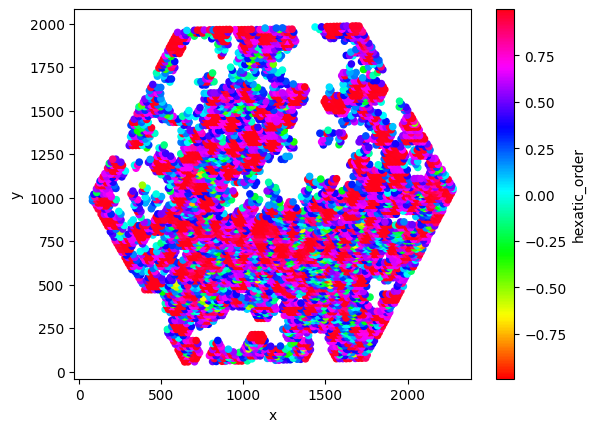

In [53]:
%matplotlib auto
frame.plot(x='x', y='y', c='hexatic_order', kind='scatter', cmap='hsv')

In [88]:

%matplotlib auto
# frame['hexatic']
toplot = frame[frame.hexatic_order_neighbours_abs>0.6]
toplot.plot(x='x', y='y', c='hexatic_order_neighbours_abs', kind='scatter', cmap='hsv')

Using matplotlib backend: Qt5Agg


<AxesSubplot:xlabel='x', ylabel='y'>

In [83]:
im = draw_image(toplot)

<ipython-input-55-96dfe70181c4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['draw_radius'] = diameter/2+2


In [84]:
images.display(im)

[]

In [36]:
contours = images.find_contours(im[:, :, 1])

In [56]:
contour_areas, hull_areas, solidities, aspect_ratios, rects = get_contour_properties(contours)
annotated_im = annotate_im_with_contours(im.copy(), contours, rects)

In [57]:
plt.hist(aspect_ratios, bins=100)

(array([5., 1., 1., 6., 0., 2., 1., 2., 4., 3., 1., 0., 3., 2., 1., 2., 4.,
        2., 3., 3., 2., 1., 2., 1., 0., 1., 0., 1., 1., 1., 4., 1., 2., 0.,
        1., 0., 1., 0., 3., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1.        , 1.02690493, 1.05380987, 1.0807148 , 1.10761974,
        1.13452467, 1.1614296 , 1.18833454, 1.21523947, 1.2421444 ,
        1.26904934, 1.29595427, 1.32285921, 1.34976414, 1.37666907,
        1.40357401, 1.43047894, 1.45738387, 1.48428881, 1.51119374,
        1.53809868, 1.56500361, 1.59190854, 1.61881348, 1.64571841,
        1.67262334, 1.69952828, 1.72643321, 1.75333815, 1.78024308,
        1.80714801, 1.83405295, 1.86095788, 1.88786281, 1.91476775,
        1.94167268, 1.96857762, 1.99548255, 2.02238748, 2.04929242,
      

In [60]:
solid_contours, solid_rects = zip(*[[c, r] for c, s, r, a in zip(contours, solidities, rects, aspect_ratios) if s > 0.7 and a < 2 and a > 1.02])
annotated_im = annotate_im_with_contours(im.copy(), solid_contours, solid_rects)

In [61]:
images.display(annotated_im)

[]

In [62]:
solid_areas, solid_hull_areas, solid_solidities, solid_aspect_ratios, solid_rects = get_contour_properties(solid_contours)

In [63]:
plt.hist(solid_areas)

(array([19.,  7.,  5.,  9.,  8.,  4.,  0.,  0.,  0.,  2.]),
 array([  796. ,  5010.7,  9225.4, 13440.1, 17654.8, 21869.5, 26084.2,
        30298.9, 34513.6, 38728.3, 42943. ]),
 <BarContainer object of 10 artists>)

In [67]:
import filehandling
from tqdm import tqdm

In [69]:
files = filehandling.list_files("/media/data/Data/BallBearing/HIPS/IslandExperiments/1,93mmRepeats/*.hdf5")

In [75]:
areas = []
for file in tqdm(files):
    try:
        data = pd.read_hdf(file)
        data['hexatic_order_abs'] = np.abs(data.hexatic_order)
        frame = data.loc[0].copy()
        frame = hexatic_order_neighbours(frame)
        toplot = frame[frame.hexatic_order_neighbours_abs>0.9]
        im = draw_image(toplot)
        contours = images.find_contours(im[:, :, 1])
        contour_areas, hull_areas, solidities, aspect_ratios, rects = get_contour_properties(contours)
        annotated_im = annotate_im_with_contours(im, contours, rects)
        # images.display(annotated_im)
        for ca, solid, aspect in zip(contour_areas, solidities, aspect_ratios):
            if solid > 0.8 and aspect < 1.5:
                areas.append(ca)
    except ValueError as e:
        print(e)

  0%|          | 0/45 [00:00<?, ?it/s]<ipython-input-55-96dfe70181c4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['draw_radius'] = diameter/2+2
 13%|█▎        | 6/45 [00:04<00:29,  1.32it/s]

The file '/media/data/Data/BallBearing/HIPS/IslandExperiments/1,93mmRepeats/19300007.hdf5' is already opened.  Please close it before reopening.  HDF5 v.1.8.5-patch1, FILE_OPEN_POLICY = 'strict'


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


In [76]:
plt.hist(areas, bins=100)

(array([1.200e+01, 1.136e+03, 0.000e+00, 0.000e+00, 4.100e+01, 1.430e+02,
        1.470e+02, 5.400e+01, 2.100e+01, 0.000e+00, 9.800e+01, 1.000e+00,
        9.500e+01, 1.200e+01, 1.300e+02, 3.400e+01, 5.300e+01, 4.000e+01,
        1.300e+01, 4.200e+01, 6.000e+00, 5.500e+01, 1.000e+01, 4.800e+01,
        2.700e+01, 3.300e+01, 5.400e+01, 1.100e+01, 5.000e+01, 3.000e+00,
        4.600e+01, 3.000e+00, 2.700e+01, 1.400e+01, 1.800e+01, 3.200e+01,
        8.000e+00, 2.900e+01, 6.000e+00, 2.400e+01, 1.200e+01, 1.700e+01,
        2.000e+01, 1.600e+01, 2.200e+01, 3.000e+00, 2.000e+01, 9.000e+00,
        1.100e+01, 1.100e+01, 1.100e+01, 1.200e+01, 3.000e+00, 1.400e+01,
        6.000e+00, 1.500e+01, 5.000e+00, 5.000e+00, 1.000e+01, 4.000e+00,
        1.500e+01, 5.000e+00, 1.200e+01, 2.000e+00, 4.000e+00, 4.000e+00,
        6.000e+00, 4.000e+00, 2.000e+00, 6.000e+00, 6.000e+00, 2.000e+00,
        1.000e+00, 4.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 4.000e+00, 1.000e+0

### Try measuring from the video directly

In [63]:
from labvision import images, video
import numpy as np
import cv2

In [81]:
vid = video.ReadVideo("/media/data/Data/BallBearing/HIPS/IslandExperiments/1,91mmRepeats/TEST/19330001.MP4")
vid2 = video.ReadVideo("/media/data/Data/BallBearing/HIPS/PhaseDiagramsNewPlate/1,95mm/80%/451.mp4")

In [82]:
frame = vid.read_next_frame()
frame2 = vid2.read_next_frame()

In [7]:
corners = images.display(frame)

In [8]:
corners

[(868, 1075),
 (1439, 127),
 (2556, 149),
 (3092, 1132),
 (2511, 2080),
 (1402, 2050)]

In [66]:
corners = [(868, 1075),
 (1439, 127),
 (2556, 149),
 (3092, 1132),
 (2511, 2080),
 (1402, 2050)]

In [67]:
class BBox:
    def __init__(self, xmin, xmax, ymin, ymax):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax

    def to_tuple(self):
        return ((self.xmin, self.ymin), (self.xmax, self.ymax))

    def to_list(self):
        return [[self.xmin, self.ymin], [self.xmax, self.ymax]]

    def __str__(self):
        s = "BBOX: xmin = {}, xmax = {}, ymin = {}, ymax = {}".format(self.xmin, self.xmax, self.ymin, self.ymax)
        return s


In [68]:
def create_crop_result_from_corners(im, corners):
    if len(im.shape) == 2:
        mask = np.zeros_like(im, dtype=np.uint8)
    else:
        mask = np.zeros_like(im[:, :, 0], dtype=np.uint8)
    bbox = BBox(min(corners[:, 0]), max(corners[:, 0]), min(corners[:, 1]), max(corners[:, 1]))
    cv2.fillPoly(mask, pts=np.array([corners], dtype=np.int32), color=(255, 255, 255))
    corners[:, 0] -= bbox.xmin
    corners[:, 1] -= bbox.ymin
    return bbox, mask




In [69]:
bbox, mask = create_crop_result_from_corners(frame, np.array(corners))

In [83]:
bbox2, mask2 = create_crop_result_from_corners(frame2, np.array(corners))

In [70]:
frame = images.crop_and_mask(frame, bbox, mask)

In [84]:
frame2 = images.crop_and_mask(frame, bbox, mask)

In [97]:
frame2 = frame2[:, :, 0]

In [71]:
frame = frame[:, :, 0]

In [90]:
images.display(frame2)

[]

In [98]:
fourier_transform2 = np.fft.fft2(frame2)

In [95]:
from matplotlib.colors import LogNorm

In [100]:
plt.imshow(np.abs(fourier_transform2), norm=LogNorm())

In [26]:
images.DilationGui(frame)

In [28]:
images.AdaptiveThresholdGui(frame)

In [29]:
images.ThresholdGui(frame)

In [43]:
thresh = images.threshold(frame, 76)
thresh = images.opening(thresh, (5, 5), kernel_type=cv2.MORPH_ELLIPSE)

In [47]:
images.display(thresh)

[]

In [45]:
images.DilationGui(thresh)

### Test for contact between particles

In [129]:
%matplotlib auto
from scipy import spatial
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from order_parameters import add_translational_order

Using matplotlib backend: Qt5Agg


In [132]:
data = pd.read_hdf("/media/data/Data/BallBearing/HIPS/IslandExperiments/1,93mmRepeats/19300001.hdf5")

In [133]:
data, lattice_vector = add_translational_order(data)

In [134]:
frame = data.loc[0]

In [135]:
tree = spatial.KDTree(frame[['x', 'y']])
dists, indices = tree.query(frame[['x', 'y']], 7)

In [136]:
dists = dists[:, 1:]

In [112]:
plt.subplot(1, 2, 1)
plt.hist(dists[:, :4], bins=100)
plt.axvline(np.median(dists[:, :4]))
plt.subplot(1, 2, 2)
plt.hist(dists, bins=100)
plt.axvline(np.median(dists))

In [137]:
points = frame[['x', 'y']].values

In [138]:
for point, ds, indxs in zip(frame[['x', 'y']].values, dists, indices):
    for d, i in zip(ds, indxs):
        if d < np.median(dists)+np.std(dists):
            plt.plot([point[0], points[i, 0]], [point[1], points[i, 1]], 'r')
        # else:
        #     plt.plot([point[0], points[i, 0]], [point[1], points[i, 1]], 'b')
plt.scatter(frame.x.values, frame.y.values, c=np.angle(frame.translational_order), cmap='hsv')
plt.colorbar()

In [17]:
plt.scatter(points[:, 0], points[:, 1])

In [26]:
dists < np.median(dists)
dists2 = [sum(d) for d in dists < np.median(dists)]

In [28]:
frame = frame.copy()

In [29]:
frame['touching_neighbours'] = dists2

In [122]:
frame = frame[frame.touching_neighbours > 2]
frame.plot(x='x', y='y', c='touching_neighbours', kind='scatter', cmap='tab10')

AttributeError: 'DataFrame' object has no attribute 'touching_neighbours'

In [140]:
plt.scatter(frame.x.values, frame.y.values, c=np.round(np.angle(frame.translational_order), 1), cmap='hsv')

In [143]:
plt.hist(np.angle(frame.translational_order), bins=1000)

(array([ 5.,  7.,  3.,  7., 11.,  4.,  8., 10.,  8.,  7.,  8.,  6., 15.,
         7.,  8.,  7.,  7.,  5.,  2.,  5.,  8., 10.,  4.,  5.,  5., 14.,
        10.,  7.,  7., 13.,  6., 12., 11.,  4.,  3.,  6.,  6.,  9., 13.,
        13.,  5., 15.,  9.,  4.,  5., 11., 11.,  8., 14., 10.,  4.,  8.,
        11., 11.,  8.,  4., 11., 10.,  6.,  5.,  7.,  6.,  7., 15.,  7.,
        15.,  8., 13., 11., 14.,  9.,  9., 10.,  9., 11., 10., 11., 15.,
        13., 10.,  7., 11.,  6.,  6.,  6.,  9., 10.,  8.,  7.,  2.,  9.,
         7., 14.,  9., 10., 11.,  8.,  7.,  9.,  4.,  6.,  4.,  8.,  8.,
        10.,  8.,  7., 16.,  5., 10., 10.,  8.,  9., 12.,  8.,  7.,  5.,
         8.,  9.,  8., 10., 12.,  9.,  4.,  5., 10.,  6.,  8., 12.,  3.,
         7.,  7.,  8.,  5., 13., 13.,  9., 10.,  7.,  8., 11.,  7.,  3.,
         5., 14., 10.,  7.,  6.,  1., 11., 11.,  8.,  8.,  8.,  2.,  4.,
         6.,  8.,  9., 10.,  5.,  6.,  6.,  9.,  8.,  3.,  7.,  5.,  7.,
         6.,  6.,  7.,  8.,  1.,  4.,  4.,  8.,  8.

### Try separating particles in clusters using translational order parameter

In [198]:

# neighbours = find_neighbours(points)

In [145]:
neighbours

[array([24, 23,  1], dtype=int32),
 array([11,  3, 24,  0, 27,  2, 39], dtype=int32),
 array([ 3,  1, 42, 39], dtype=int32),
 array([11,  1,  7,  5,  4, 44, 42,  2], dtype=int32),
 array([ 3,  5, 44, 45], dtype=int32),
 array([ 6,  7,  3,  4, 45, 46], dtype=int32),
 array([ 5,  7, 52, 46], dtype=int32),
 array([ 6,  5, 52, 36,  3, 11,  8], dtype=int32),
 array([36,  7, 11,  9, 55], dtype=int32),
 array([10, 11, 56,  8, 55], dtype=int32),
 array([ 9, 11, 12, 56, 60], dtype=int32),
 array([10,  9, 12, 13,  3,  1,  7,  8, 15, 14, 17, 57, 18], dtype=int32),
 array([10, 11, 13, 60, 61], dtype=int32),
 array([12, 11, 61, 82, 57], dtype=int32),
 array([15, 19, 11, 66, 65, 18], dtype=int32),
 array([16, 72, 71, 14, 19, 11, 17, 28], dtype=int32),
 array([17, 72, 15], dtype=int32),
 array([16, 72, 75, 21, 20, 22, 25, 26, 69, 15, 11], dtype=int32),
 array([57, 11, 65, 14], dtype=int32),
 array([14, 15, 28, 70, 66], dtype=int32),
 array([29, 22, 83, 17, 25, 79], dtype=int32),
 array([17, 75, 25, 7

In [193]:
import time

In [196]:
# plt.figure()
# plt.ion()
trans_angle = np.angle(frame.translational_order)
clusters = np.zeros(len(points))
# scatt = plt.scatter(frame.x, frame.y, c=clusters, cmap='tab20', vmax=50)
current_cluster = 1
for i, (p, n) in enumerate(zip(points, neighbours)):
    cluster_no_store = current_cluster
    # Check to see if starting position is on a cluster
    if clusters[i] == 0:
        clusters[i] = current_cluster
    else:
        current_cluster = clusters[i]

    # Check which neighbours have similar angles
    current_angle = trans_angle[i]
    neighbour_angles = trans_angle[n]
    angle_differences = np.abs(current_angle - neighbour_angles)
    n = n[angle_differences < 0.01]

    # Check to see if neighbours are already in a cluster
    neighbour_clusters = clusters[n]
    equivalent_clusters = neighbour_clusters[np.nonzero(neighbour_clusters)]
    equivalent_clusters = np.append(equivalent_clusters, current_cluster)

    # Set the neighbours cluster values to the current cluster
    clusters[n] = current_cluster

    # Overwrite equivalent clusters
    lowest_cluster = np.min(equivalent_clusters)
    for j in range(len(equivalent_clusters)):
        cluster_no_temp = equivalent_clusters[j]
        ints = np.where(clusters == cluster_no_temp)
        clusters[ints] = lowest_cluster

    current_cluster = cluster_no_store + 1
    # scatt.set_array(clusters)
    # time.sleep(0.1)

In [197]:
plt.subplot(1, 2, 1)
plt.scatter(frame.x, frame.y, c=np.angle(frame.translational_order), cmap='hsv')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.scatter(frame.x, frame.y, c=clusters, cmap='tab20')

In [205]:
from collections import deque

In [226]:
def find_neighbours(points):
    tess = spatial.Delaunay(points)
    list_indices, points_indices = tess.vertex_neighbor_vertices
    neighbours = [points_indices[i:j] for i, j in zip(list_indices[:-1], list_indices[1:])]
    return neighbours

def add_clusters(frame, angle_threshold):
    trans_angle = np.angle(frame.translational_order)
    clusters = np.zeros(len(points))
    current_cluster = 1
    unused_indexes = deque([i for i in range(len(frame))])
    current_indexes = deque([])
    neighbours_all_points = find_neighbours(frame[['x', 'y']].values)
    while len(unused_indexes) > 0:
        index = unused_indexes.popleft()
        current_indexes.append(index)
        # Go through the new queue
        while len(current_indexes) > 0:
            index = current_indexes.popleft()
            clusters[index] = current_cluster
            # Check which neighbours have similar angles
            current_angle = trans_angle[index]
            neighbours = neighbours_all_points[index]
            neighbours_angles = trans_angle[neighbours]
            angle_differences = np.abs(current_angle - neighbours_angles)
            neighbours = neighbours[angle_differences < angle_threshold]

            # Remove these from the first queue and add to the second queue
            for n in neighbours:
                if n in unused_indexes:
                    unused_indexes.remove(n)
                    current_indexes.append(n)
        current_cluster += 1
    frame['cluster'] = clusters
    return frame


In [263]:
frame_with_clusters = add_clusters(frame.copy(), 0.1)

In [342]:
def plot_clusters(df):
    plt.subplot(1, 2, 1)
    plt.scatter(df.x, df.y, c=np.angle(df.translational_order), cmap='hsv')
    def annotate(a):
        if len(a) > 3:
            hull = spatial.ConvexHull(a[['x', 'y']].values)
            i = hull.vertices
            i = np.append(i, hull.vertices[0])
            plt.plot(a.x.values[i], a.y.values[i], 'r--')
    df.groupby('cluster').apply(annotate)
    plt.axis('equal')
    plt.subplot(1, 2, 2)
    plt.scatter(df.x, df.y, c=np.abs(df.hexatic_order), cmap='hsv')
    df.groupby('cluster').apply(annotate)
    plt.axis('equal')

### Try checking pairs of neighbouring particles to make sure one has high hexatic order

In [331]:
def find_neighbours(points):
    tess = spatial.Delaunay(points)
    list_indices, points_indices = tess.vertex_neighbor_vertices
    neighbours = [points_indices[i:j] for i, j in zip(list_indices[:-1], list_indices[1:])]
    return neighbours

def add_clusters(frame, angle_threshold, hexatic_threshold):
    trans_angle = np.angle(frame.translational_order)
    hexatic = np.abs(frame.hexatic_order.values)
    clusters = np.zeros(len(points))
    current_cluster = 1
    unused_indexes = deque([i for i in range(len(frame))])
    current_indexes = deque([])
    neighbours_all_points = find_neighbours(frame[['x', 'y']].values)
    print(type(neighbours_all_points))
    while len(unused_indexes) > 0:
        index = unused_indexes.popleft()
        current_indexes.append(index)
        # Go through the new queue
        while len(current_indexes) > 0:
            index = current_indexes.popleft()
            clusters[index] = current_cluster
            # Check which neighbours have similar angles
            current_angle = trans_angle[index]
            neighbours = neighbours_all_points[index]
            print(type(neighbours))
            neighbours_angles = trans_angle[neighbours]
            angle_differences = np.abs(current_angle - neighbours_angles)
            neighbours = neighbours[angle_differences < angle_threshold]
            # Check if one of the neighbouring pairs has high hexatic order
            if hexatic[index] > hexatic_threshold:
                pass
            else:
                hexatic_neighbours = hexatic[neighbours]
                neighbours = neighbours[hexatic_neighbours > hexatic_threshold]

            # Remove these from the first queue and add to the second queue
            for n in neighbours:
                if n in unused_indexes:
                    unused_indexes.remove(n)
                    current_indexes.append(n)
        current_cluster += 1
    frame['cluster'] = clusters
    return frame

In [332]:
frame_with_clusters = add_clusters(frame.copy(), 0.1, 0.8)

<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<

KeyboardInterrupt: 

In [ ]:
from particletracking import statistics
statistics.order

In [316]:
plot_clusters(frame_with_clusters)

In [291]:
counts = frame_with_clusters.groupby('cluster').count().x.values
plt.hist(counts, bins=np.arange(100))

(array([0.000e+00, 2.182e+03, 1.350e+02, 7.400e+01, 4.200e+01, 2.000e+01,
        1.700e+01, 1.600e+01, 1.100e+01, 6.000e+00, 8.000e+00, 8.000e+00,
        4.000e+00, 4.000e+00, 8.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        1.000e+00, 7.000e+00, 6.000e+00, 3.000e+00, 8.000e+00, 5.000e+00,
        1.000e+00, 4.000e+00, 3.000e+00, 5.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

#### Compare cluster size to mean hexatic order

In [ ]:
counts = frame_with_clusters.groupby('cluster').count().x.values

In [294]:
frame_with_clusters['hexatic_order_abs'] = np.abs(frame_with_clusters['hexatic_order'])

In [297]:
average_hexatic = frame_with_clusters.groupby('cluster').mean().hexatic_order_abs.values

In [301]:
std_hexatic = frame_with_clusters.groupby('cluster').std().hexatic_order_abs.values

In [308]:
# plt.plot(counts, average_hexatic, 'x')
plt.errorbar(counts, average_hexatic, std_hexatic/np.sqrt(counts), fmt='x', capsize=5)
plt.xlabel('Size of cluster')
plt.ylabel('Mean hexatic order')

Text(0, 0.5, 'Mean hexatic order')

In [302]:
from mpl_toolkits import mplot3d

### Add a distance threshold to the neighbours

In [337]:
def find_vectors(points, list_indices, point_indices):
    repeat = list_indices[1:] - list_indices[:-1]
    return points[point_indices] - np.repeat(points, repeat, axis=0)

def estimate_diameter(points):
    tree = spatial.KDTree(points)
    dists, indices = tree.query(points, 7)
    diameter = np.median(dists)
    return diameter

def filter_vectors(vectors, threshold):
    length = np.linalg.norm(vectors, axis=1)
    return length < threshold

def find_neighbours(points, threshold):
    tess = spatial.Delaunay(points)
    list_indices, points_indices = tess.vertex_neighbor_vertices
    vectors = find_vectors(points, list_indices, points_indices)
    filtered = filter_vectors(vectors, threshold)
    def check(p_indices, filtered):
        return np.array([p for p, f in zip(p_indices, filtered) if f])
    neighbours = [check(points_indices[i:j], filtered[i:j]) for i, j in zip(list_indices[:-1], list_indices[1:])]
    return neighbours

def add_clusters(frame, angle_threshold, hexatic_threshold, distance_threshold):
    trans_angle = np.angle(frame.translational_order)
    hexatic = np.abs(frame.hexatic_order.values)
    clusters = np.zeros(len(points))
    current_cluster = 1
    unused_indexes = deque([i for i in range(len(frame))])
    current_indexes = deque([])
    neighbours_all_points = find_neighbours(frame[['x', 'y']].values, distance_threshold)
    while len(unused_indexes) > 0:
        index = unused_indexes.popleft()
        current_indexes.append(index)
        # Go through the new queue
        while len(current_indexes) > 0:
            index = current_indexes.popleft()
            clusters[index] = current_cluster
            # Check which neighbours have similar angles
            current_angle = trans_angle[index]
            neighbours = neighbours_all_points[index]
            if len(neighbours) == 0:
                continue
            neighbours_angles = trans_angle[neighbours]
            angle_differences = np.abs(current_angle - neighbours_angles)
            neighbours = neighbours[angle_differences < angle_threshold]
            # Check if one of the neighbouring pairs has high hexatic order
            if hexatic[index] > hexatic_threshold:
                pass
            else:
                hexatic_neighbours = hexatic[neighbours]
                neighbours = neighbours[hexatic_neighbours > hexatic_threshold]

            # Remove these from the first queue and add to the second queue
            for n in neighbours:
                if n in unused_indexes:
                    unused_indexes.remove(n)
                    current_indexes.append(n)
        current_cluster += 1
    frame['cluster'] = clusters
    return frame

In [345]:
diameter = estimate_diameter(frame[['x', 'y']].values)
frame_with_clusters = add_clusters(frame.copy(), 0.2, 0.8, 2*diameter)

In [346]:
plot_clusters(frame_with_clusters)